# ULM Sentiment Classifier

In [1]:
from fastai.text import *
import html
print(torch.__version__)
print(np.__version__)
# torch version should be pre 1.0 for compatibility with Fastai 0.7
# np version should be 1.15 for compatibility with Fastai 0.7

%run -i ./code/sentiment_imdb_helpers.py


0.3.1.post2
1.15.1


In [2]:

PATH=Path('data/aclImdb/')
# in NLP you will see LM (Language Model) path by convention
LM_PATH=Path('data/imdb_lm/')
LM_PATH.mkdir(exist_ok=True)
# Clas Path and Col Names
CLAS_PATH=Path('data/imdb_clas/')
CLAS_PATH.mkdir(exist_ok=True)
chunksize=24000
col_names = ['labels','text']


#### Read in and prepare data

In [3]:
# Load Data

#uncomment the nextlines only the first time to load imdb data and create dataframes
#%run -i ./code/sentiment_imdb_load_createdf.py
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

# Tokenize
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

# Load Vocabulary
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
print('vocabulary length',len(itos))

trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
trn_labels = np.squeeze(trn_labels)
val_labels = np.squeeze(val_labels)
print('trn_labels.shape', trn_labels.shape)

0
1
0
1
vocabulary length 60002
trn_labels.shape (25000,)


#### Define Classifier

In [5]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
#opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48 # originally bs of 48 ... reduce to 42 for memory purposes

md = make_ModelDataLoader(trn_clas, trn_labels, val_clas, val_labels, bs)

print(bs, bptt)

dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5
# change 20*70 to 10*70 ... running out of memory with 20 * 70 ... see notes/comments below

c=int(trn_labels.max())+1
m = get_rnn_classifer(bptt, 10*70, c, vs, emb_sz=em_sz, n_hid=nh, 
                      n_layers=nl, pad_token=1,
                      layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
                      dropouti=dps[0], wdrop=dps[1],        
                      dropoute=dps[2], dropouth=dps[3])
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))


#learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=partial(optim.Adam, betas=(0.7, 0.99)))
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]


48 70


#### Learn

In [10]:

lr=3e-3
wd = 0
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

# load language model
learn.load_encoder('lm1_enc')  # this model is saved under PATH/models/lm1_enc


In [11]:

learn.freeze_to(-1)
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

# bs 48, bptt = 70
#epoch      trn_loss   val_loss   accuracy                      
#    0      0.278688   0.179933   0.93148   

epoch      trn_loss   val_loss   accuracy                      
    0      0.278688   0.179933   0.93148   



[array([0.17993]), 0.9314800004959106]

In [12]:
learn.save('clas_0')


In [13]:
learn.load('clas_0')

In [14]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

# bs = 48, bptt = 70
#epoch      trn_loss   val_loss   accuracy                      
#    0      0.230364   0.164364   0.93696   
    
# bs = 40, bptt = 70
#epoch      trn_loss   val_loss   accuracy                      
#    0      0.340473   0.17319    0.933125
#[0.17319041, 0.9331253991245995]

epoch      trn_loss   val_loss   accuracy                      
    0      0.230364   0.164364   0.93696   



[array([0.16436]), 0.9369600005340576]

In [15]:
learn.save('clas_1')


In [16]:
learn.load('clas_1')

In [17]:
learn.unfreeze()
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

# bs = 48, bptt = 70, 10*70
#epoch      trn_loss   val_loss   accuracy                      
#    0      0.205568   0.158957   0.94092   
#    1      0.206695   0.161946   0.94032 
#    5      0.118354   0.160345   0.94368                        
#    6      0.095922   0.183031   0.94532                        
#    7      0.069187   0.85192    0.94112 
#   12     0.029799   0.255404    0.94524                        
#    13     0.030276   0.246786   0.94448 

# bs = 48, bptt = 70, 20*70
#epoch      trn_loss   val_loss   accuracy                      
#    0      0.337347   0.186812   0.930782  
#    1      0.284065   0.318038   0.932062                      
#    2      0.246721   0.156018   0.941747                      
#    3      0.252745   0.157223   0.944106                      
#    4      0.24023    0.159444   0.945393                      
#    5      0.210046   0.202856   0.942858                      
#    6      0.212139   0.149009   0.943746                      
#    7      0.21163    0.186739   0.946553                      
#    8      0.186233   0.1508     0.945218                      
#    9      0.176225   0.150472   0.947985                      
#    10     0.198024   0.146215   0.948345                      
#    11     0.20324    0.189206   0.948145                      
#    12     0.165159   0.151402   0.947745                      
#    13     0.165997   0.146615   0.947905

epoch      trn_loss   val_loss   accuracy                      
    0      0.205568   0.158957   0.94092   
    1      0.206695   0.161946   0.94032                       
 67%|██████▋   | 703/1042 [12:30<08:05,  1.43s/it, loss=0.181]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    5      0.118354   0.160345   0.94368                        
    6      0.095922   0.183031   0.94532                        
    7      0.069187   0.85192    0.94112                        
 19%|█▉        | 196/1042 [03:19<18:09,  1.29s/it, loss=0.0656]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    12     0.029799   0.255404   0.94524                        
    13     0.030276   0.246786   0.94448                        



[array([0.24679]), 0.9444799982643127]

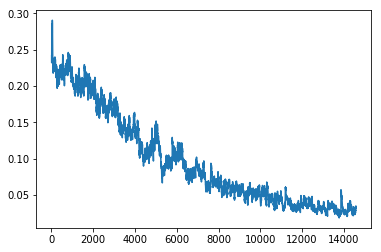

In [18]:
learn.sched.plot_loss()
learn.save('clas_2')